In [9]:
import argparse
import cv2
import glob
import numpy as np
import time
import shutil
import os
import re
import torch
from basicsr.utils import imwrite

from ultralytics import YOLO

from gfpgan import GFPGANer

from Facial_Expression_Recognition import facial_expression_detection

from FaceRecognize import FaceRecognize

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 定义全局常量
EMOTION_MAPPING = {'Angry': -2, 'Disgust': -1, 'Fear': -1, 'Happy': 2, 'Sad': -1, 'Surprise': 2, 'Neutral': 1}
BEHAVIOR_MAPPING = {'0': -2, '1': -1, '2': 2, '3': 1}
ATTENDANCE_MIN_SCORE = -2
ATTENDANCE_MAX_SCORE = 2

In [10]:
def main(input_folder):
    """Inference demo for GFPGAN (for users).
    """
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '-i',
        '--input',
        type=str,
        default=input_folder,
        help='Input image or folder. Default: inputs/whole_imgs')
    parser.add_argument('-o', '--output', type=str, default='results', help='Output folder. Default: results')
    # we use version to select models, which is more user-friendly
    parser.add_argument(
        '-v', '--version', type=str, default='1.3', help='GFPGAN model version. Option: 1 | 1.2 | 1.3. Default: 1.3')
    parser.add_argument(
        '-s', '--upscale', type=int, default=2, help='The final upsampling scale of the image. Default: 2')

    parser.add_argument(
        '--bg_upsampler', type=str, default='realesrgan', help='background upsampler. Default: realesrgan')
    parser.add_argument(
        '--bg_tile',
        type=int,
        default=400,
        help='Tile size for background sampler, 0 for no tile during testing. Default: 400')
    parser.add_argument('--suffix', type=str, default=None, help='Suffix of the restored faces')
    parser.add_argument('--only_center_face', action='store_true', help='Only restore the center face')
    parser.add_argument('--aligned', action='store_true', help='Input are aligned faces')
    parser.add_argument(
        '--ext',
        type=str,
        default='auto',
        help='Image extension. Options: auto | jpg | png, auto means using the same extension as inputs. Default: auto')
    parser.add_argument('-w', '--weight', type=float, default=0.5, help='Adjustable weights.')
    args = parser.parse_args()

    args = parser.parse_args()

    # ------------------------ input & output ------------------------
    if args.input.endswith('/'):
        args.input = args.input[:-1]
    if os.path.isfile(args.input):
        img_list = [args.input]
    else:
        img_list = sorted(glob.glob(os.path.join(args.input, '*')))

    os.makedirs(args.output, exist_ok=True)

    # ------------------------ set up background upsampler ------------------------
    if args.bg_upsampler == 'realesrgan':
        if not torch.cuda.is_available():  # CPU
            import warnings
            warnings.warn('The unoptimized RealESRGAN is slow on CPU. We do not use it. '
                          'If you really want to use it, please modify the corresponding codes.')
            bg_upsampler = None
        else:
            from basicsr.archs.rrdbnet_arch import RRDBNet
            from realesrgan import RealESRGANer
            model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
            bg_upsampler = RealESRGANer(
                scale=2,
                model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
                model=model,
                tile=args.bg_tile,
                tile_pad=10,
                pre_pad=0,
                half=True)  # need to set False in CPU mode
    else:
        bg_upsampler = None

    # ------------------------ set up GFPGAN restorer ------------------------
    if args.version == '1':
        arch = 'original'
        channel_multiplier = 1
        model_name = 'GFPGANv1'
        url = 'https://github.com/TencentARC/GFPGAN/releases/download/v0.1.0/GFPGANv1.pth'
    elif args.version == '1.2':
        arch = 'clean'
        channel_multiplier = 2
        model_name = 'GFPGANCleanv1-NoCE-C2'
        url = 'https://github.com/TencentARC/GFPGAN/releases/download/v0.2.0/GFPGANCleanv1-NoCE-C2.pth'
    elif args.version == '1.3':
        arch = 'clean'
        channel_multiplier = 2
        model_name = 'GFPGANv1.3'
        url = 'https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth'
    elif args.version == '1.4':
        arch = 'clean'
        channel_multiplier = 2
        model_name = 'GFPGANv1.4'
        url = 'https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.4.pth'
    elif args.version == 'RestoreFormer':
        arch = 'RestoreFormer'
        channel_multiplier = 2
        model_name = 'RestoreFormer'
        url = 'https://github.com/TencentARC/GFPGAN/releases/download/v1.3.4/RestoreFormer.pth'
    else:
        raise ValueError(f'Wrong model version {args.version}.')

    # determine model paths
    model_path = os.path.join('experiments/pretrained_models', model_name + '.pth')
    if not os.path.isfile(model_path):
        model_path = os.path.join('gfpgan/weights', model_name + '.pth')
    if not os.path.isfile(model_path):
        # download pre-trained models from url
        model_path = url

    restorer = GFPGANer(
        model_path=model_path,
        upscale=args.upscale,
        arch=arch,
        channel_multiplier=channel_multiplier,
        bg_upsampler=bg_upsampler)

    # ------------------------ restore ------------------------
    for img_path in img_list:
        # read image
        img_name = os.path.basename(img_path)
        print(f'Processing {img_name} ...')
        basename, ext = os.path.splitext(img_name)
        input_img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # restore faces and background if necessary
        cropped_faces, restored_faces, restored_img = restorer.enhance(
            input_img,
            has_aligned=args.aligned,
            only_center_face=args.only_center_face,
            paste_back=True,
            weight=args.weight)

        # save faces
        for idx, (cropped_face, restored_face) in enumerate(zip(cropped_faces, restored_faces)):
            # save cropped face
            save_crop_path = os.path.join(args.output, 'cropped_faces', f'{basename}_{idx:02d}.png')
            imwrite(cropped_face, save_crop_path)
            # save restored face
            if args.suffix is not None:
                save_face_name = f'{basename}_{idx:02d}_{args.suffix}.png'
            else:
                save_face_name = f'{basename}_{idx:02d}.png'
            save_restore_path = os.path.join(args.output, 'restored_faces', save_face_name)
            imwrite(restored_face, save_restore_path)
            # save comparison image
            cmp_img = np.concatenate((cropped_face, restored_face), axis=1)
            imwrite(cmp_img, os.path.join(args.output, 'cmp', f'{basename}_{idx:02d}.png'))

        # save restored img
        if restored_img is not None:
            if args.ext == 'auto':
                extension = ext[1:]
            else:
                extension = args.ext

            if args.suffix is not None:
                save_restore_path = os.path.join(args.output, 'restored_imgs', f'{basename}_{args.suffix}.{extension}')
            else:
                save_restore_path = os.path.join(args.output, 'restored_imgs', f'{basename}.{extension}')
            imwrite(restored_img, save_restore_path)

    print(f'Results are in the [{args.output}] folder.')


In [11]:

def extract_frames_from_video(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(int(total_frames / 15), 1)  # 取视频100分之1的帧作为输入

    output_count = 1
    curr_frame = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if curr_frame % frame_interval == 0:
            output_path = os.path.join(output_folder, f'frame_{output_count:05d}.png')
            cv2.imwrite(output_path, frame)
            output_count += 1

        curr_frame += 1

    cap.release()


In [12]:
def detect_input(input_path):
    if os.path.isfile(input_path):
        # 判断文件是否为视频格式
        video_extensions = ['.mov', '.mp4', '.avi', '.mkv']
        file_extension = os.path.splitext(input_path)[1].lower()
        if file_extension in video_extensions:
            return 'video'
        else:
            return 'image'
    elif os.path.isdir(input_path):
        # 判断是图片文件夹还是视频文件夹
        # 这里根据实际情况判断文件夹内的内容类型
        return 'image_folder'
    else:
        print('Invalid input.')
        return None


In [13]:
def process_video_or_image(input_path, output_folder):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)  # 如果输出文件夹存在则删除
        print(f"删除已存在文件夹: {output_folder}")

    print('开始检测输入')
    input_type = detect_input(input_path)

    if input_type == 'video':
        print('检测到输入为：视频，开始抽帧')
        # 创建输出文件夹
        os.makedirs(output_folder, exist_ok=True)
        # 提取并保存视频帧
        extract_frames_from_video(input_path, output_folder)
        print('所抽取帧已保存到指定文件夹')
    elif input_type == 'image':
        print('检测到输入为：图片，将输入文件保存到输出文件夹')
        # 复制输入文件到输出文件夹
        shutil.copy2(input_path, output_folder)
    elif input_type == 'image_folder':
        print('检测到输入为：图片文件夹，将所有图片文件保存到输出文件夹')
        # 获取图片文件夹中的所有文件
        image_files = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
        # 创建输出文件夹
        os.makedirs(output_folder, exist_ok=True)
        # 复制所有图片文件到输出文件夹
        for image_file in image_files:
            shutil.copy2(os.path.join(input_path, image_file), output_folder)
    else:
        print('Invalid input.')


In [14]:
def read_emotion_labels(file_path):
    emotion_mapping = {'Angry': -2, 'Disgust': -1, 'Fear': -1, 'Happy': 2, 'Sad': -1, 'Surprise': 2, 'Neutral': 1}
    emotion_labels = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        image_name, emotion = line.strip().split(':')
        emotion = emotion.strip()
        if emotion in emotion_mapping:
            emotion_labels[image_name] = emotion_mapping[emotion]

    return emotion_labels


In [15]:

def calculate_emotion_counts(emotion_labels):
    counts = [0, 0, 0, 0]  # 对应 积极, 较为积极, 中性, 消极

    for emotion in emotion_labels.values():
        if emotion == 2:
            counts[0] += 1  # 积极
        elif emotion == 1:
            counts[1] += 1  # 较为积极
        elif emotion == -1:
            counts[2] += 1  # 中性
        elif emotion == -2:
            counts[3] += 1  # 消极

    return counts

In [16]:
# ---------------课堂出勤得分----------------
def calculate_attendance_score(attended_people, total_people):
    min_score = -2
    max_score = 2
    percentage = attended_people / total_people if total_people != 0 else 0
    score = min_score + percentage * (max_score - min_score)
    return score

In [17]:
# ----------------行为识别得分----------------
def calculate_behavior_counts(folder_path):
    counts = [0, 0, 0, 0]  # 对应 积极, 较为积极, 中性, 消极

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                data = file.readlines()
                for line in data:
                    behavior = line.strip().split()[0]
                    if behavior == '2':
                        counts[0] += 1  # 积极
                    elif behavior == '3':
                        counts[1] += 1  # 较为积极
                    elif behavior == '1':
                        counts[2] += 1  # 中性
                    elif behavior == '0':
                        counts[3] += 1  # 消极

    return counts

In [18]:
# ----------------综合教学效果评价----------------
def evaluate_class_effectiveness(attendance_score, behavior_counts, emotion_counts):
    # 计算公式中的 N^t_p 及评价
    N_behavior = behavior_counts
    N_emotion = emotion_counts

    # 避免除以零，若消极人数为零时设定一个较小值
    N_behavior[3] = N_behavior[3] if N_behavior[3] != 0 else 1
    N_emotion[3] = N_emotion[3] if N_emotion[3] != 0 else 1

    R_behavior = sum(N_behavior[:3]) / (2 * N_behavior[3])
    R_emotion = sum(N_emotion[:3]) / (2 * N_emotion[3])

    # 计算最终评分
    R = attendance_score * (R_behavior + R_emotion)

    # 根据公式Func(R)进行最终评分
    if R >= 2:
        final_score = 2
    elif 1.5 <= R < 2:
        final_score = 1
    elif 1 <= R < 1.5:
        final_score = 0
    else:
        final_score = -1

    return final_score

In [21]:
if __name__ == '__main__':
    process = process_video_or_image('test_video/1.mp4', 'inputs')

    temp_path = 'E:/code/py/github/GFPGAN/results'

    for root, dirs, files in os.walk(temp_path, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            shutil.rmtree(os.path.join(root, dir))

    attend_num = 44
    attend_num = int(attend_num)
    start_time = time.time()
    main('inputs')
    print('-------------情绪检测, start!-----------')
    model_path = 'Facial_Expression_Recognition/FER2013_VGG19/PrivateTest_model.t7'
    image_folder_path = 'results/restored_faces'
    output_folder_path = 'results/emotion_faces'

    # 创建 FacialExpressionDetector 实例
    print('学生情绪检测中................')
    detector = facial_expression_detection.FacialExpressionDetector(model_path, image_folder_path, output_folder_path)
    print('-------------情绪检测, done!-------------')


    print('-------------人脸识别，启动！------------')
    fr_img_path = 'E:/code/py/github/GFPGAN/results/restored_imgs'
    fr_out_path = 'E:/code/py/github/GFPGAN/results/face_recognize'
    qiandao_txt_path = './qiandao.txt'
    fr = FaceRecognize.FaceRecognizer()
    fr.start_recognize(fr_img_path, fr_out_path, qiandao_txt_path, 'attendance.xlsx')
    print('正在进行人脸识别............')

    # 处理图像并保存结果
    detector.process_images()
    print('-------------人脸识别，完成！------------')




    # ----------------------读取表情识别结果
    emotxt_file_path = 'results/emotion_faces/results.txt' # 修改为你的文件路径
    emotion_labels = read_emotion_labels(emotxt_file_path)
    # 计算学生表现综合得分
    emo_performance = calculate_emotion_counts(emotion_labels)
    print("情绪识别：该堂课的学生表现综合得分为:", emo_performance)





    # ---------------------学生行为识别
    yolo_folder_path = r'E:/code/py/github/GFPGAN/yolo_runs/detect'
    prefix = 'predict'

    # 遍历文件夹内的所有文件夹
    folder_count = 0
    for folder_name in os.listdir(yolo_folder_path):
        # 判断文件夹是否以给定前缀开始
        if folder_name.startswith(prefix) and os.path.isdir(os.path.join(yolo_folder_path, folder_name)):
            folder_count += 1

    print('---------------开始进行行为检测---------------')

    yolo_model = YOLO('checkpoint/best.pt')
    print('YOLOv8模型已加载')
    yolo_model.predict('inputs', save=True, save_txt=True)
    print('-----------------行为检测完成---------------')
    if folder_count != 0:
        behavior_file_path = f'yolo_runs/detect/predict{folder_count + 1 }/labels'
    else:
        behavior_file_path = f'yolo_runs/detect/predict/labels'
    be_performance = calculate_behavior_counts(behavior_file_path)
    print("行为识别：该堂课的学生表现质量为:", be_performance)





    # ----------------------出勤得分
    # 初始化一个空的字典来存储文件名和识别人脸数量
    face_count_dict = {}
    invalid_count_files = []  # 用于记录无效计数值的文件名

    with open(qiandao_txt_path, 'r') as file:
        for line in file:
            file_name, count = line.split(':')
            count = count.strip()  # 去掉两端空格
            count_match = re.search(r'\d+', count)  # 使用正则表达式提取数字部分
            if count_match:
                face_count_dict[file_name.strip()] = int(count_match.group())
            else:
                invalid_count_files.append(file_name.strip())
                print(f"Invalid count value for file {file_name.strip()}: {count}")

    # 取出最大的人脸数量
    max_face_count = max(face_count_dict.values())

    print(f'应到{attend_num}人，实到{max_face_count}人，出勤率为{max_face_count/attend_num*100}%')
    chuqin_scr = calculate_attendance_score(attend_num, max_face_count)
    print('出勤：该堂课的学生表现质量为:', chuqin_scr)

    # R = (emo_average_performance*0.3 + be_average_performance*0.3 + chuqin_scr*0.4)
    R = evaluate_class_effectiveness(chuqin_scr, be_performance, emo_performance)

    end_time = time.time()


    print('该课堂综合评分为：', R)
    print('----------------------------------------------')
    if R == 2:
        print("这节课教学效果评价为：好！")
    elif R == 1:
        print("这节课教学效果评价为：较好~")
    elif R == 0:
        print("这节课教学效果评价为：一般般")
    else:
        print("这节课教学效果评价为：差")

    print('程序运行时长：', end_time - start_time, 's')

usage: ipykernel_launcher.py [-h] [-i INPUT] [-o OUTPUT] [-v VERSION]
                             [-s UPSCALE] [--bg_upsampler BG_UPSAMPLER]
                             [--bg_tile BG_TILE] [--suffix SUFFIX]
                             [--only_center_face] [--aligned] [--ext EXT]
                             [-w WEIGHT]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\18070\AppData\Roaming\jupyter\runtime\kernel-v2-24260Ew48Dxr4QZDo.json


SystemExit: 2

In [ ]:
3.84
10.07
5.42
7.64
5.35
12.0
4.97
5.86
6.57
6.07
5.83
1.97
4.71
4.95
5.49
2.29

2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2

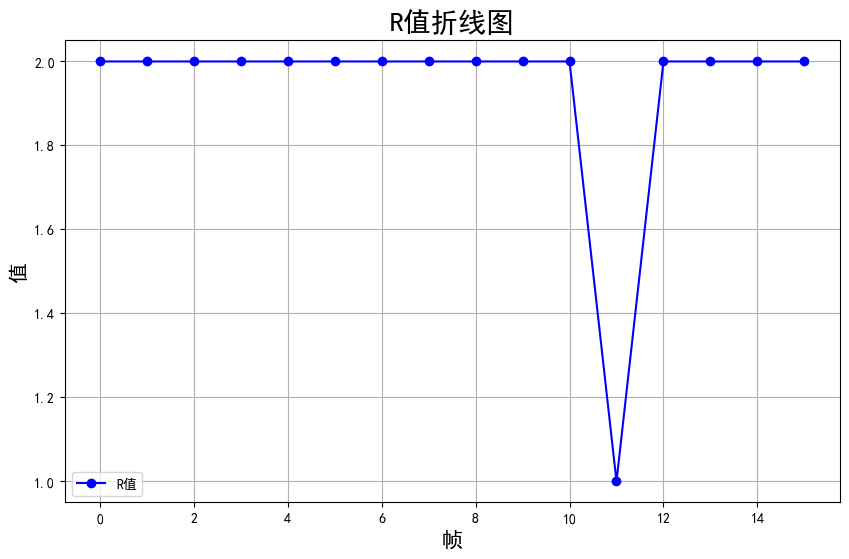

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 数据
# data = [3.84, 10.07, 5.42, 7.64, 5.35, 12.0, 4.97, 5.86, 6.57, 6.07, 5.83, 1.97, 4.71, 4.95, 5.49, 2.29]

data = [2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
1,
2,
2,
2,
2]

# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 替换为你的系统中文字体路径
my_font = fm.FontProperties(fname=font_path)

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(data, marker='o', linestyle='-', color='b', label='R值')

# 添加标题和标签
plt.title('R值折线图', fontproperties=my_font, fontsize=20)
plt.xlabel('帧', fontproperties=my_font, fontsize=15)
plt.ylabel('值', fontproperties=my_font, fontsize=15)

# 设置刻度字体
plt.xticks(fontproperties=my_font)
plt.yticks(fontproperties=my_font)

# 显示网格
plt.grid(True)

# 显示图例
plt.legend(prop=my_font)

# 显示图形
plt.show()
